# Installs and Imports

In [2]:
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [3]:
# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

# Loading the model

In [4]:
# camera mode: 0 (fixed), 1 (following)
camera_mode = 0

In [5]:
import numpy as np

class Planar2RLegKinematics:
    def __init__(
        self,
        l1, l2, hip_x, hip_z,
        hip_offset=np.pi,
        knee_offset=0,
        ankle_offset=-np.pi/2,
        hip_sign=1.0,
        knee_sign=1.0,
        ankle_sign=1.0,
        elbow_sign=-1.0,
    ):
        self.l1 = float(l1)
        self.l2 = float(l2)
        self.hip_x = float(hip_x)
        self.hip_z = float(hip_z)

        # geometry = sign * (hw + offset)
        self.hip_offset   = float(hip_offset)
        self.knee_offset  = float(knee_offset)
        self.ankle_offset = float(ankle_offset)

        self.hip_sign   = float(hip_sign)
        self.knee_sign  = float(knee_sign)
        self.ankle_sign = float(ankle_sign)

        # +1 / -1 → elbow-down / elbow-up (or vice versa, depending on your convention)
        self.elbow_sign = float(elbow_sign)

    def foot_position(self, hip_hw, knee_hw, ankle_hw=0.0):
        hip_geom  = self.hip_sign  * (hip_hw  + self.hip_offset)
        knee_geom = self.knee_sign * (knee_hw + self.knee_offset)
        # ankle_geom = self.ankle_sign * (ankle_hw + self.ankle_offset)

        th1 = hip_geom
        th2 = hip_geom + knee_geom

        x = self.hip_x + self.l1 * np.sin(th1) + self.l2 * np.sin(th2)
        z = self.hip_z - self.l1 * np.cos(th1) - self.l2 * np.cos(th2)
        return float(x), float(z)

    def inverse_kinematics(self, x, z):
        # --- same hip/knee geometry IK as before ---

        x_rel = x - self.hip_x
        z_rel = z - self.hip_z

        if abs(z_rel) < 1e-6:
            z_rel = np.sign(z_rel) * 1e-6 if z_rel != 0 else 1e-6

        hipRad2 = np.arctan2(x_rel, z_rel)
        c = np.cos(hipRad2)
        if abs(c) < 1e-6:
            c = np.sign(c) * 1e-6 if c != 0 else 1e-6

        z2 = z_rel / c

        def safe_acos(arg):
            return np.arccos(np.clip(arg, -1.0, 1.0))

        l1, l2 = self.l1, self.l2

        hipRad1 = safe_acos((l1**2 + z2**2 - l2**2) / (2.0 * l1 * z2))
        knee_geom = np.pi - safe_acos((l1**2 + l2**2 - z2**2) / (2.0 * l1 * l2))

        hip_geom = self.elbow_sign * hipRad1 + hipRad2

        # --- ankle to keep foot horizontal ---
        lower_orient = hip_geom + knee_geom            # orientation of lower leg
        desired_foot_orient = np.pi / 2.0              # horizontal in your "from down" convention
        ankle_geom = desired_foot_orient - lower_orient

        # --- convert to hardware angles ---
        hip_hw   = (hip_geom   / self.hip_sign)   - self.hip_offset
        knee_hw  = (knee_geom  / self.knee_sign)  - self.knee_offset
        ankle_hw = (ankle_geom / self.ankle_sign) - self.ankle_offset

        return hip_hw, knee_hw, ankle_hw

class BipedForwardKinematics:
    """
    Convenience wrapper for both legs, in the (x, z) plane.

    Assumes 6 leg joint angles in this order:
        [hipL, kneeL, ankleL, hipR, kneeR, ankleR]
    (You can change indices via the constructor.)

    The constructor takes the *explicit hip coordinates*:
        (left_hip_x, left_hip_z), (right_hip_x, right_hip_z)
    """

    def __init__(
        self,
        upper_leg_length,
        lower_leg_length,
        left_hip_x,
        left_hip_z,
        right_hip_x,
        right_hip_z,
        idx_hipL=0, idx_kneeL=1, idx_ankleL=2,
        idx_hipR=3, idx_kneeR=4, idx_ankleR=5,
    ):
        self.left_leg = Planar2RLegKinematics(
            l1=upper_leg_length,
            l2=lower_leg_length,
            hip_x=left_hip_x,
            hip_z=left_hip_z,
        )
        self.right_leg = Planar2RLegKinematics(
            l1=upper_leg_length,
            l2=lower_leg_length,
            hip_x=right_hip_x,
            hip_z=right_hip_z,
        )

        # Joint index mapping (within your 6-D leg joint vector)
        self.idx_hipL = idx_hipL
        self.idx_kneeL = idx_kneeL
        self.idx_ankleL = idx_ankleL
        self.idx_hipR = idx_hipR
        self.idx_kneeR = idx_kneeR
        self.idx_ankleR = idx_ankleR

    def feet_from_joint_angles(self, joint_angles):
        """
        joint_angles: iterable/array-like of length >= 6
                      [hipL, kneeL, ankleL, hipR, kneeR, ankleR]

        Returns:
          dict with:
            "left":  (xL, zL)
            "right": (xR, zR)
        """
        joint_angles = np.asarray(joint_angles, dtype=np.float64)

        hipL = joint_angles[self.idx_hipL]
        kneeL = joint_angles[self.idx_kneeL]
        hipR = joint_angles[self.idx_hipR]
        kneeR = joint_angles[self.idx_kneeR]

        xL, zL = self.left_leg.foot_position(hipL, kneeL)
        xR, zR = self.right_leg.foot_position(hipR, kneeR)

        return {
            "left":  (xL, zL),
            "right": (xR, zR),
        }

    def inverse_for_both(self, xL, zL, xR, zR):
        """
        Optional helper: inverse kinematics for both legs at once.

        Returns:
          (hipL, kneeL, ankleL, hipR, kneeR, ankleR)
        """
        hipL, kneeL, ankleL = self.left_leg.inverse_kinematics(xL, zL)
        hipR, kneeR, ankleR = self.right_leg.inverse_kinematics(xR, zR)
        return np.array([hipL, kneeL, ankleL, hipR, kneeR, ankleR], dtype=np.float64)


In [6]:
L1 = 0.05   # same as L1
L2 = 0.058  # same as L2

LEFT_HIP_X  = 0.0   # tune this
RIGHT_HIP_X = 0.0   # tune this
HIP_Z       = 0.12205  # or whatever matches your model

fk_model = BipedForwardKinematics(
    upper_leg_length=L1,
    lower_leg_length=L2,
    left_hip_x=0.0,
    left_hip_z=HIP_Z,
    right_hip_x=0.0,
    right_hip_z=HIP_Z,
)

In [8]:
import PIL.Image
import numpy as np
from dm_control import composer, mjcf
from dm_control.locomotion.arenas import floors
from scipy.spatial.transform import Rotation as R
from dm_control.composer.observation import observable

class Biped(composer.Entity):
    def _build(self, xml_path="drive/MyDrive/biped/model.xml"):
        self._mjcf_model = mjcf.from_path(xml_path)

        # Visualization marker for left foot target (world frame)
        # self._mjcf_model.worldbody.add(
        #     'site',
        #     name='left_foot_target',
        #     type='sphere',
        #     size=(0.05,),
        #     rgba=(1, 0, 0, 0)
        # )

        # self._mjcf_model.worldbody.add(
        #     'site',
        #     name='right_foot_target',
        #     type='sphere',
        #     size=(0.05,),
        #     rgba=(0, 1, 0, 1)
        # )

    @property
    def mjcf_model(self):
        return self._mjcf_model

    def _build_observables(self):
        return BipedObservables(self)

class BipedObservables(composer.Observables):

    @composer.observable
    def joint_positions(self):
        """All joint positions from qpos."""
        joints = self._entity.mjcf_model.find_all('joint')
        return observable.MJCFFeature('qpos', joints)

    @composer.observable
    def joint_velocities(self):
        """All joint velocities from qvel."""
        joints = self._entity.mjcf_model.find_all('joint')
        return observable.MJCFFeature('qvel', joints)

    @composer.observable
    def imu(self):
        """Accelerometer + gyro at imu_site (imu_acc, imu_gyro)."""
        root = self._entity.mjcf_model
        all_sensors = root.find_all('sensor')
        imu_sensors = [
            s for s in all_sensors
            if s.tag in ('accelerometer', 'gyro')
        ]
        # Optional: sort by name for deterministic ordering
        imu_sensors.sort(key=lambda s: s.name)
        return observable.MJCFFeature('sensordata', imu_sensors)

    @composer.observable
    def foot_contacts(self):
        """Left and right foot contact (touch sensors on soles)."""
        root = self._entity.mjcf_model
        all_sensors = root.find_all('sensor')
        contact_sensors = [s for s in all_sensors if s.tag == 'touch']
        contact_sensors.sort(key=lambda s: s.name)

        obs = observable.MJCFFeature('sensordata', contact_sensors)

        # Turn continuous force -> binary contact with a small threshold
        def binarize(values, random_state):
            return (values > 10).astype(np.float32) # disable contacts

        obs.corruptor = binarize
        return obs

class WalkingTask(composer.Task):
    def __init__(self, robot, fk_model, randomizer_strength=0.0,
                 randomizer_region=None):
        self._robot = robot
        self._robot.mjcf_model.worldbody.add('light', pos=(0, 0, 4))

        self._height_threshold = 0.14
        self._max_orientation_angle = 45.0  # degrees
        self._target_height = 0.17

        self._robot.observables.enable_all()

        self._fk_model = fk_model
        self._randomizer_strength = randomizer_strength
        self._tilt_penalty = -0.25

        self._last_feet_x_avg = None

        # Default small region around nominal stance
        if randomizer_region is None:
            randomizer_region = {
                "x_range": (-0.02, 0.02),
                "z_range": (0.0145, 0.04), # can not be lower than 0.014
            }
        self._randomizer_region = randomizer_region

    @property
    def root_entity(self):
        return self._robot

    def initialize_episode(self, physics, random_state):
        root_dofs = 7  # free joint: 3 pos + 4 quat

        # Reset internal state
        physics.named.data.qpos[root_dofs:] = 0.0
        physics.named.data.qvel[:] = 0.0

        self._last_feet_x_avg = None

        joint_start = root_dofs
        joint_end = joint_start + 6  # [hipL, kneeL, ankleL, hipR, kneeR, ankleR]

        # --- Foot-space randomization ---
        if False and self._randomizer_region is not None and self._fk_model is not None:
            x_low, x_high = self._randomizer_region["x_range"]
            z_low, z_high = self._randomizer_region["z_range"]

            # Sample desired left/right foot positions in foot-space
            xL = random_state.uniform(x_low, x_high)
            zL = random_state.uniform(z_low, z_high)
            xR = random_state.uniform(x_low, x_high)
            zR = random_state.uniform(z_low, z_high)

        # print(f"left leg:({xL}, {zL})")
        # print(f"right leg:({xR}, {zR})")

        # physics.named.model.site_pos['left_foot_target'] = [xL, 0.119, zL]
        # physics.named.model.site_pos['right_foot_target'] = [xR, 0.20, zR]
        # physics.forward()  # recompute all derived quantities


            # Inverse kinematics: get joint angles for both legs
            # Expecting: [hipL, kneeL, ankleL, hipR, kneeR, ankleR]
            q_leg = self._fk_model.inverse_for_both(xL, zL, xR, zR)

            # Set the internal joint angles
            physics.data.qpos[joint_start:joint_end] = q_leg

        else:
            # fallback: old joint-space randomization if region/FK is not set
            physics.named.data.qpos[joint_start:joint_end] += random_state.uniform(
                low=-self._randomizer_strength,
                high=self._randomizer_strength,
                size=joint_end - joint_start,
            )

        physics.forward()

        left_toe_pos = physics.named.data.site_xpos["left_toe"]
        right_toe_pos = physics.named.data.site_xpos["right_toe"]
        x_avg = 0.5 * (left_toe_pos[0] + right_toe_pos[0])
        self._last_feet_x_avg = x_avg

    def should_terminate_episode(self, physics):
        """End episode early if the robot's center of mass falls too low or orientation exceeds threshold."""
        com_pos = physics.data.qpos[:3].copy()
        com_height = com_pos[2]

        # Check if COM height is below the threshold
        if com_height < self._height_threshold:
            return True

        # Check if the orientation exceeds the threshold
        quat = physics.data.qpos[3:7]  # Quaternion representing the orientation

        # Convert quaternion to Euler angles (roll, pitch, yaw)
        rotation = R.from_quat(quat)
        euler_angles = rotation.as_euler('xyz', degrees=True)  # Get roll, pitch, yaw in degrees
        roll, pitch, yaw = euler_angles

        # Check if the pitch angle exceeds the threshold
        # low  = 90 - self._max_orientation_angle
        # high = 90 + self._max_orientation_angle

        if not (np.abs(yaw) < self._max_orientation_angle):
            return True

        return False

    def get_reward(self, physics):
        # --------- 1) Feet progress in world frame (MAIN TERM) ---------
        # Option A: feet defined as SITES
        left_foot_pos  = physics.named.data.site_xpos['left_toe']
        right_foot_pos = physics.named.data.site_xpos['right_toe']

        # If your feet are BODIES instead, use this instead:
        # left_foot_pos  = physics.named.data.xpos['left_foot']
        # right_foot_pos = physics.named.data.xpos['right_foot']

        # Average x-position of both feet in world coordinates
        x_avg = 0.5 * (left_foot_pos[0] + right_foot_pos[0])

        if self._last_feet_x_avg is None:
            # First step in the episode: no progress yet
            step_progress = 0.0
        else:
            dx = x_avg - self._last_feet_x_avg
            # Reward *forward* motion only (assuming +x is forward):
            step_progress = max(0.0, dx)

            # If you instead want to reward *any* stepping (forward/back):
            # step_progress = abs(dx)

        # Update for next timestep
        self._last_feet_x_avg = x_avg

        # --------- 2) Stabilizing terms based on COM / orientation ---------
        com_pos = physics.data.qpos[:3].copy()
        y = com_pos[1]
        z_ref = self._target_height
        z_tilde = (com_pos[2] - z_ref) / z_ref

        torques = physics.data.actuator_force
        torque_penalty = np.sum(np.square(torques))

        Ts = physics.model.opt.timestep

        # Orientation → yaw in degrees
        quat = physics.data.qpos[3:7]
        rotation = R.from_quat(quat)
        roll, pitch, yaw = rotation.as_euler('xyz', degrees=True)

        if np.abs(yaw) <= self._max_orientation_angle:
            yaw_penalty = -0.5 * (np.abs(yaw) / self._max_orientation_angle)
        else:
            yaw_penalty = -0.5

        # --------- 3) Combine into reward components ---------
        comp = {
            # MAIN positive term: feet moved forward in world x
            "step_progress": 50.0 * step_progress,

            # Keep COM near center line & target height
            "y_penalty": 0 * -30.0 * (y ** 2),
            "z_penalty": 0 * -30.0 * (z_tilde ** 2),

            # Small alive bonus so standing isn’t terrible
            "time_bonus": 0 * 10.0 * Ts,

            # Regularization
            "torque_penalty": 0 * -0.05 * torque_penalty,
            "yaw_penalty": 0 * yaw_penalty,
        }

        r_t = sum(comp.values())

        # For your VideoEvalCallback overlays
        physics.data.reward_components = comp

        return float(r_t)


# --- Build environment ---
robot = Biped(xml_path="model.xml")
task = WalkingTask(
    robot=robot,
    fk_model=fk_model,
    randomizer_strength=0.0,
    randomizer_region = {
        "x_range": (-0.01, 0.04),
        "z_range": (0.025, 0.03),
    })
env = composer.Environment(task=task, time_limit=10)

# --- Test rendering ---
time_step = env.reset()
pixels = env.physics.render(camera_id=camera_mode, width=400, height=400)
PIL.Image.fromarray(pixels)

RuntimeError: No OpenGL rendering backend is available.

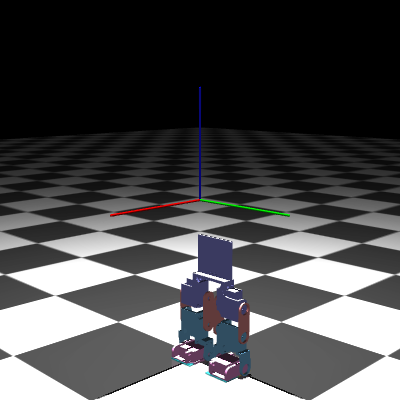

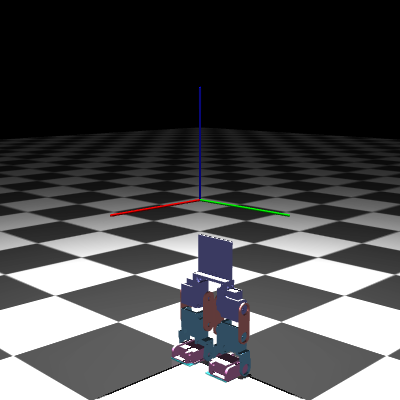

In [11]:
import numpy as np
import PIL.Image

np.random.seed(seed=42)

# Reset
env.reset()

# Step through 100 steps
for i in range(100):
    # Sample random actions in the allowed range
    # action = np.random.uniform(
    #     env.action_spec().minimum,
    #     env.action_spec().maximum,
    # )
    action = [0, 0, 0, 0, 0, 0]
    timestep = env.step(action)
    # print(timestep.observation.keys())
    # print(timestep.observation["joint_positions"]) # odict_keys(['biped/joint_positions', 'biped/joint_velocities'])

    # print(timestep)


    if i == 0 or i == 99:  # see point 2 below
        pixels = env.physics.render(camera_id=camera_mode, width=400, height=400)
        img = PIL.Image.fromarray(pixels)
        display(img)

In [12]:
# import numpy as np
# import PIL.Image
# import imageio.v2 as imageio  # pip install imageio if needed

# # Reset env
# timestep = env.reset()

# target_x = 0.05
# target_y = 0.119     #119
# target_z = 0.05     #12205

# # 2) Set the marker site to the target (world coords: x,y,z)
# env.physics.named.model.site_pos['left_foot_target'] = [target_x, target_y, target_z]

# # 3) Use IK to compute the left leg joint targets for this (y,z)
# hipR, kneeR, ankleR = fk_model.right_leg.inverse_kinematics(target_x, target_z)
# print("targets:", hipR, kneeR, ankleR)

# root_dofs = 7  # 3 pos + 4 quat
# joint_start = root_dofs
# joint_end   = joint_start + 6  # [hipL, kneeL, ankleL, hipR, kneeR, ankleR]

# # Current joint configuration
# q_current = env.physics.data.qpos[joint_start:joint_end].copy()
# print("current: ", q_current)

# # Desired joint configuration (only right leg; left leg stays as-is)
# q_target = q_current.copy()
# q_target[fk_model.idx_hipR]   = hipR
# q_target[fk_model.idx_kneeR]  = kneeR
# q_target[fk_model.idx_ankleR] = ankleR

# # 4) Interpolate joints over 100 "steps" (purely kinematic) and collect frames
# num_steps = 3
# frames = []

# for i in range(num_steps):
#     alpha = (i + 1) / num_steps
#     q_interp = (1 - alpha) * q_current + alpha * q_target

#     env.physics.data.qpos[joint_start:joint_end] = q_interp
#     env.physics.data.qvel[:] = 0.0
#     env.physics.forward()  # recompute all derived quantities

#     # Render and store this frame
#     frame = env.physics.render(camera_id=camera_mode, width=400, height=400)
#     frames.append(frame)

# # 5) Save frames as a small video
# fps = 30
# imageio.mimsave("fk_test.mp4", frames, fps=fps, macro_block_size=None)
# print("Saved video as fk_test.mp4")

# # Optionally show the last frame as an image in the notebook
# img = PIL.Image.fromarray(frames[-1])
# display(img)

In [13]:
from collections import deque
import dm_env
from dm_env import specs
import numpy as np

class FootSpacePdEnv(dm_env.Environment):
    """
    High-level continuous foot-space control with IK + PD.

    Action: a_t ∈ [-1, 1]^6 interpreted as *deltas*:
        [ΔxL, ΔzL, ΔxR, ΔzR, ΔΔankleL, ΔΔankleR]

    Internal state:
        - last_targets = [xL, zL, xR, zR, ankleOffsetL, ankleOffsetR]
        - PD controller maps IK joint targets to torques

    Observations:
        - original dm_control observations
        - 'control_state' (as before)
        - 'foot_history': stacked (xL, zL, xR, zR) for last K steps
    """

    def __init__(
        self,
        base_env,
        fk_model,
        x_range=(-0.04, 0.08),   # allowed absolute x range [m]
        z_range=(0.015, 0.08),   # allowed absolute z range [m]
        Kp=40.0,
        Kd=4.0,
        foot_delta_max=(0.005, 0.005),      # max per-step Δx, Δz [m]
        ankle_delta_max_deg=10.0,         # max per-step change in ankle offset [deg]
        ankle_abs_max_deg=45.0,           # absolute ankle offset limit [deg]
        history_len=4,                    # number of past foot positions to stack
    ):
        self._env = base_env
        self._fk = fk_model
        self._x_min, self._x_max = x_range
        self._z_min, self._z_max = z_range
        self._Kp = Kp
        self._Kd = Kd

        self._dx_max, self._dz_max = foot_delta_max
        self._ankle_delta_max = np.deg2rad(ankle_delta_max_deg)
        self._ankle_abs_max = np.deg2rad(ankle_abs_max_deg)
        self._history_len = history_len

        physics = self._env.physics
        self._n_joints = self._env.action_spec().shape[0]

        # root DOFs for positions and velocities:
        self._root_pos_dofs = physics.data.qpos.size - self._n_joints
        self._root_vel_dofs = physics.data.qvel.size - self._n_joints

        print(
            f"[FootSpacePdEnv] qpos={physics.data.qpos.size}, "
            f"qvel={physics.data.qvel.size}, n_joints={self._n_joints}, "
            f"root_pos_dofs={self._root_pos_dofs}, root_vel_dofs={self._root_vel_dofs}"
        )

        # High-level 6D continuous action in [-1, 1]
        self._action_spec = specs.BoundedArray(
            shape=(6,),
            dtype=np.float32,
            minimum=-np.ones(6, dtype=np.float32),
            maximum=+np.ones(6, dtype=np.float32),
            name="foot_target_deltas",
        )

        # --- Internal controller state for richer observations ---
        self._last_action = np.zeros(self._action_spec.shape, dtype=np.float32)
        self._last_q_des = np.zeros(self._n_joints, dtype=np.float32)
        self._last_tau = np.zeros(self._n_joints, dtype=np.float32)

        # Absolute targets in foot space + ankle offsets:
        # [xL, zL, xR, zR, ankleOffsetL, ankleOffsetR]
        self._last_targets = np.zeros(6, dtype=np.float32)

        # History of foot positions: deque of [xL, zL, xR, zR]
        self._foot_history = deque(maxlen=self._history_len)

    # ------------------------------------------------------------------
    # dm_env boilerplate
    # ------------------------------------------------------------------

    def reset(self):
        """Reset base env and internal controller/foot state."""
        ts = self._env.reset()
        physics = self._env.physics

        # Reset controller state
        self._last_action[:] = 0.0
        self._last_q_des[:] = 0.0
        self._last_tau[:] = 0.0

        # Initialize foot targets from current foot positions + zero ankle offsets
        left_foot_pos = physics.named.data.site_xpos["left_toe"]
        right_foot_pos = physics.named.data.site_xpos["right_toe"]
        xL, zL = left_foot_pos[0], left_foot_pos[2]
        xR, zR = right_foot_pos[0], right_foot_pos[2]

        # Clamp to valid ranges (just in case)
        xL = np.clip(xL, self._x_min, self._x_max)
        xR = np.clip(xR, self._x_min, self._x_max)
        zL = np.clip(zL, self._z_min, self._z_max)
        zR = np.clip(zR, self._z_min, self._z_max)

        self._last_targets[:] = np.array([xL, zL, xR, zR, 0.0, 0.0], dtype=np.float32)

        # Reset foot history to current position repeated K times
        self._foot_history.clear()
        for _ in range(self._history_len):
            self._foot_history.append(np.array([xL, zL, xR, zR], dtype=np.float32))

        obs = self._get_augmented_observation(ts)
        return dm_env.TimeStep(
            step_type=ts.step_type,
            reward=ts.reward,
            discount=ts.discount,
            observation=obs,
        )

    def step(self, action):
        """Apply high-level *delta* foot-space action via IK + PD, then augment obs."""
        action = np.asarray(action, dtype=np.float32)

        # --- Map normalized action -> physical deltas ---
        d_xL, d_zL, d_xR, d_zR, d_dAnkleL, d_dAnkleR = self._rescale_action(action)

        # Previous absolute targets
        xL_prev, zL_prev, xR_prev, zR_prev, ankleL_prev, ankleR_prev = self._last_targets

        # Integrate and clamp foot positions
        xL_des = np.clip(xL_prev + d_xL, self._x_min, self._x_max)
        zL_des = np.clip(zL_prev + d_zL, self._z_min, self._z_max)
        xR_des = np.clip(xR_prev + d_xR, self._x_min, self._x_max)
        zR_des = np.clip(zR_prev + d_zR, self._z_min, self._z_max)

        # Integrate ankle offsets and clamp to absolute limits
        ankleL_off = np.clip(ankleL_prev + d_dAnkleL, -self._ankle_abs_max, self._ankle_abs_max)
        ankleR_off = np.clip(ankleR_prev + d_dAnkleR, -self._ankle_abs_max, self._ankle_abs_max)

        # Save updated absolute targets
        self._last_targets[:] = np.array(
            [xL_des, zL_des, xR_des, zR_des, ankleL_off, ankleR_off],
            dtype=np.float32,
        )

        # --- IK: desired foot positions -> nominal joint angles (flat foot) ---
        q_des = self._fk.inverse_for_both(xL_des, zL_des, xR_des, zR_des)
        q_des = q_des.copy()
        q_des[2] += ankleL_off  # left ankle
        q_des[5] += ankleR_off  # right ankle

        physics = self._env.physics
        q = physics.data.qpos[
            self._root_pos_dofs : self._root_pos_dofs + self._n_joints
        ]
        qdot = physics.data.qvel[
            self._root_vel_dofs : self._root_vel_dofs + self._n_joints
        ]

        # --- PD control in joint space ---
        e = q_des - q
        edot = -qdot
        tau_leg = self._Kp * e + self._Kd * edot

        # Clip to actuator limits
        act_spec = self._env.action_spec()
        tau = np.clip(tau_leg, act_spec.minimum, act_spec.maximum)

        # Store controller state
        self._last_action = action.copy()
        self._last_q_des = q_des.copy()
        self._last_tau = tau.copy()

        # Step underlying env
        ts = self._env.step(tau)

        # Update foot history with *actual* positions after physics
        self._update_foot_history()

        obs = self._get_augmented_observation(ts)
        return dm_env.TimeStep(
            step_type=ts.step_type,
            reward=ts.reward,
            discount=ts.discount,
            observation=obs,
        )

    # ------------------------------------------------------------------
    # Specs and helpers
    # ------------------------------------------------------------------

    def observation_spec(self):
        """
        Return base observation spec plus 'control_state' and 'foot_history'.
        """
        base_spec = self._env.observation_spec()
        spec_dict = dict(base_spec)

        action_dim = self._action_spec.shape[0]
        control_dim = 5 * self._n_joints + action_dim

        spec_dict["control_state"] = specs.BoundedArray(
            shape=(control_dim,),
            dtype=np.float32,
            minimum=-np.inf * np.ones(control_dim, dtype=np.float32),
            maximum=+np.inf * np.ones(control_dim, dtype=np.float32),
            name="control_state",
        )

        foot_dim = 4 * self._history_len  # xL,zL,xR,zR over history
        spec_dict["foot_history"] = specs.BoundedArray(
            shape=(foot_dim,),
            dtype=np.float32,
            minimum=-np.inf * np.ones(foot_dim, dtype=np.float32),
            maximum=+np.inf * np.ones(foot_dim, dtype=np.float32),
            name="foot_history",
        )

        return spec_dict

    def action_spec(self):
        return self._action_spec

    @property
    def physics(self):
        return self._env.physics

    # ------------------------------------------------------------------
    # Internal helpers
    # ------------------------------------------------------------------

    def _get_augmented_observation(self, ts: dm_env.TimeStep):
        """
        Take a base TimeStep from the underlying env and augment the observation
        dict with 'control_state' and 'foot_history'.
        """
        obs = dict(ts.observation)
        obs["control_state"] = self._compute_control_state()
        obs["foot_history"] = self._get_flat_foot_history()
        return obs

    def _compute_control_state(self):
        """
        Build the 'control_state' vector based on current physics and stored
        controller state.
        """
        physics = self._env.physics
        q = physics.data.qpos[
            self._root_pos_dofs : self._root_pos_dofs + self._n_joints
        ]
        qdot = physics.data.qvel[
            self._root_vel_dofs : self._root_vel_dofs + self._n_joints
        ]

        err_q = self._last_q_des - q

        control_state = np.concatenate(
            [
                q.astype(np.float32),
                qdot.astype(np.float32),
                self._last_action.astype(np.float32),
                self._last_q_des.astype(np.float32),
                err_q.astype(np.float32),
                self._last_tau.astype(np.float32),
            ],
            axis=0,
        )
        return control_state

    def _update_foot_history(self):
        """Append current foot positions [xL,zL,xR,zR] to the history deque."""
        physics = self._env.physics
        left_foot_pos = physics.named.data.site_xpos["left_toe"]
        right_foot_pos = physics.named.data.site_xpos["right_toe"]

        xL, zL = left_foot_pos[0], left_foot_pos[2]
        xR, zR = right_foot_pos[0], right_foot_pos[2]

        self._foot_history.append(
            np.array([xL, zL, xR, zR], dtype=np.float32)
        )

        # If we haven't filled the deque yet (e.g., right after reset),
        # just keep duplicating the first element. (Handled in reset anyway.)

    def _get_flat_foot_history(self):
        """
        Return stacked foot history as a flat vector of shape (4 * history_len,).
        If the history deque is shorter (very early in training), pad by
        repeating the oldest entry.
        """
        if len(self._foot_history) == 0:
            return np.zeros(4 * self._history_len, dtype=np.float32)

        # Ensure we have exactly history_len entries by padding oldest
        entries = list(self._foot_history)
        while len(entries) < self._history_len:
            entries.insert(0, entries[0])

        entries = entries[-self._history_len :]
        return np.concatenate(entries, axis=0).astype(np.float32)

    def _rescale_action(self, a):
        """
        Map normalized action in [-1, 1]^6 to *deltas*:
          ΔxL, ΔzL, ΔxR, ΔzR in meters
          ΔΔankle_L, ΔΔankle_R in radians (per-step change in ankle offset)
        """
        a = np.clip(a, -1.0, 1.0)
        axL, azL, axR, azR, aAL, aAR = a

        d_xL = self._dx_max * axL
        d_zL = self._dz_max * azL
        d_xR = self._dx_max * axR
        d_zR = self._dz_max * azR

        d_dAnkleL = self._ankle_delta_max * aAL
        d_dAnkleR = self._ankle_delta_max * aAR

        return d_xL, d_zL, d_xR, d_zR, d_dAnkleL, d_dAnkleR

In [14]:
import numpy as np
import gymnasium as gym

class ActionRepeatEnv(gym.Env):
    def __init__(self, env, repeat=5):
        super().__init__()
        self.env = env
        self.repeat = repeat
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        total_reward = 0.0
        done = False
        info = {}
        obs = None

        for _ in range(self.repeat):
            obs, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            done = terminated or truncated
            if done:
                break

        return obs, total_reward, terminated, truncated, info

In [15]:
import gymnasium as gym
from dm_env import specs

class DmControlToGym(gym.Env):
    def __init__(self, dm_env):
        self._env = dm_env
        obs_spec = self._env.observation_spec()
        act_spec = self._env.action_spec()

        # Flatten observation dict to array
        from gymnasium.spaces import Box
        self.observation_space = Box(
            low=-np.inf, high=np.inf,
            shape=(sum(np.prod(v.shape) for v in obs_spec.values()),),
            dtype=np.float64,
        )
        self.action_space = Box(
            low=act_spec.minimum,
            high=act_spec.maximum,
            dtype=np.float64,
        )

    def reset(self, *, seed=None, options=None):
        timestep = self._env.reset()
        obs = self._flatten_obs(timestep.observation)
        return obs, {}

    def step(self, action):
        timestep = self._env.step(action)
        obs = self._flatten_obs(timestep.observation)
        reward = timestep.reward or 0.0
        terminated = timestep.last()
        truncated = False
        return obs, reward, terminated, truncated, {}

    def _flatten_obs(self, obs):
        return np.concatenate([v.ravel() for v in obs.values()])

In [16]:
import os
import cv2
import PIL.Image
import numpy as np
import imageio.v2 as imageio
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
from scipy.spatial.transform import Rotation as R
from stable_baselines3.common.callbacks import BaseCallback

def save_video(frames, path="videos/eval.mp4", fps=60):
    """Save a list of frames (numpy arrays) to an MP4 file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imageio.mimsave(path, frames, fps=fps, macro_block_size=None)
    print(f"💾 Saved video: {path}")


class VideoEvalCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=10_000, framerate=30, smooth_window=10):
        super().__init__()
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.framerate = framerate
        self.smooth_window = smooth_window

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            print(f"\n🎥  Recording full episode at training step {self.n_calls:,}...")
            self.record_full_episode()
        return True

    def record_full_episode(self):
        timestep = self.eval_env.reset()
        frames = []
        reward_buffer = deque(maxlen=self.smooth_window)

        while not timestep.last():
            # --- Policy action ---
            obs_vec = np.concatenate([v.ravel() for v in timestep.observation.values()])
            action, _ = self.model.predict(obs_vec, deterministic=True)
            timestep = self.eval_env.step(action)

            physics = self.eval_env.physics

            # --- Reward components ---
            comp = getattr(physics.data, "reward_components", {})
            total_reward = sum(comp.values()) if comp else 0.0
            reward_buffer.append(total_reward)

            # --- COM position and velocity ---
            com_pos = physics.data.qpos[:3].copy()
            com_vel = physics.data.qvel[:3].copy()

            # --- COM orientation (Euler angles) ---
            quat = physics.data.qpos[3:7].copy()
            rotation = R.from_quat(quat)
            euler_angles = rotation.as_euler("xyz", degrees=True)
            roll, pitch, yaw = euler_angles

            # ---------- IMU + foot contact readings ----------
            imu_acc = imu_gyro = None
            left_toe = left_heel = right_toe = right_heel = None

            # Use current timestep.observation (after the step)
            obs_dict = timestep.observation

            # IMU: [accx, accy, accz, gyrox, gyroy, gyroz]
            if "biped/imu" in obs_dict:
                imu = obs_dict["biped/imu"].ravel()
                if imu.size >= 3:
                    imu_acc = imu[:3]
                if imu.size >= 6:
                    imu_gyro = imu[3:6]

            # Foot contacts: [left_toe, left_heel, right_toe, right_heel]
            if "foot_contacts" in obs_dict:
                contacts = obs_dict["foot_contacts"].ravel()
                if contacts.size >= 4:
                    left_toe, left_heel, right_toe, right_heel = (
                        contacts[0], contacts[1], contacts[2], contacts[3]
                    )
            # ------------------------------------------------------

            frame = physics.render(camera_id=camera_mode, width=600, height=400).copy()

            # --- Draw overlays ---
            avg_reward = np.mean(reward_buffer)
            y0, dy = 30, 25
            cv2.putText(frame, f"Avg reward (~0.33s): {avg_reward:6.3f}", (10, y0),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

            # Reward components
            for i, (k, v) in enumerate(comp.items()):
                text = f"{k}: {v:+.3f}"
                cv2.putText(frame, text, (10, y0 + (i+1)*dy),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 1, cv2.LINE_AA)

            # COM overlays
            offset = y0 + (len(comp) + 2) * dy
            cv2.putText(frame, f"COM pos [x,y,z]: ({com_pos[0]:+.3f}, {com_pos[1]:+.3f}, {com_pos[2]:+.3f})",
                        (10, offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame, f"COM vel [x,y,z]: ({com_vel[0]:+.3f}, {com_vel[1]:+.3f}, {com_vel[2]:+.3f})",
                        (10, offset + dy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1, cv2.LINE_AA)

            cv2.putText(frame, f"COM r/p/y [deg]: ({roll:+.1f}, {pitch:+.1f}, {yaw:+.1f})",
             (10, offset + 2 * dy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 1, cv2.LINE_AA)

            # ---------- overlay IMU + contacts ----------
            extra_offset = offset + 3 * dy

            if imu_acc is not None:
                cv2.putText(frame,
                            f"IMU acc [x,y,z]: ({imu_acc[0]:+.2f}, {imu_acc[1]:+.2f}, {imu_acc[2]:+.2f})",
                            (10, extra_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,255), 1, cv2.LINE_AA)
                extra_offset += dy

            if imu_gyro is not None:
                cv2.putText(frame,
                            f"IMU gyro [x,y,z]: ({imu_gyro[0]:+.2f}, {imu_gyro[1]:+.2f}, {imu_gyro[2]:+.2f})",
                            (10, extra_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,255), 1, cv2.LINE_AA)
                extra_offset += dy

            if (left_toe is not None) and (left_heel is not None) and \
            (right_toe is not None) and (right_heel is not None):
                cv2.putText(
                    frame,
                    f"Contact [l_toe, l_heel, r_toe, r_heel]: ({left_toe}, {left_heel}, {right_toe}, {right_heel})",
                    (10, extra_offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1, cv2.LINE_AA
                )
                extra_offset += dy

            # ---------- overlay ACTION ----------
            # Flatten and maybe truncate for readability
            act_vec = np.asarray(action).ravel()
            max_to_show = 8  # in case your action space grows later
            if act_vec.size > max_to_show:
                shown = act_vec[:max_to_show]
                suffix = " ..."
            else:
                shown = act_vec
                suffix = ""
            act_str = ", ".join(f"{a:+.2f}" for a in shown)

            cv2.putText(
                frame,
                f"Action: [{act_str}{suffix}]",
                (10, extra_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,200,0), 1, cv2.LINE_AA
            )
            # ---------------------------------------------------

            frames.append(frame)

        save_video(
            frames,
            path=f"drive/MyDrive/biped/videos/episode_{self.n_calls}.mp4",
            fps=self.framerate,
        )


class PeriodicSaveCallback(BaseCallback):
    def __init__(self, save_freq, save_path, verbose=1):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:
            save_file = os.path.join(self.save_path, f"model_step_{self.n_calls}.zip")
            self.model.save(save_file)
            if self.verbose > 0:
                print(f"💾 Saved model at step {self.n_calls}: {save_file}")
        return True


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [17]:
# print(env.physics.model.ngeom)
print([env.physics.model.body(i).name for i in range(env.physics.model.nbody)])

for i in range(env.physics.model.nbody):
    print(f"{env.physics.model.body(i).name}: {env.physics.model.body(i).mass}kg")

['world', 'axis_indicator', 'biped', 'hips', 'left_connectors', 'left_leg', 'left_foot', 'right_connectors', 'right_leg', 'right_foot']
world: [0.]kg
axis_indicator: [0.]kg
biped: [0.]kg
hips: [0.15613186]kg
left_connectors: [0.01407262]kg
left_leg: [0.1617796]kg
left_foot: [0.19996122]kg
right_connectors: [0.01407262]kg
right_leg: [0.1617796]kg
right_foot: [0.19996123]kg


In [ ]:
robot = Biped(xml_path="drive/MyDrive/biped/model.xml")
task = WalkingTask(
    robot=robot,
    fk_model=fk_model,
    randomizer_strength=0.0,
    randomizer_region = {
        "x_range": (-0.01, 0.04),
        "z_range": (0.025, 0.03),
    })
env = composer.Environment(task=task, time_limit=10,
                           random_state=np.random.RandomState())


fk_model = BipedForwardKinematics(
    upper_leg_length=L1,
    lower_leg_length=L2,
    left_hip_x=0.0,
    left_hip_z=HIP_Z,
    right_hip_x=0.0,
    right_hip_z=HIP_Z,
)

# --- Wrap dm_control env with foot-space PD controller ---
pd_env = FootSpacePdEnv(
    base_env=env,
    fk_model=fk_model,
    x_range=(-0.04, 0.08),   # physical range [m] for foot x
    z_range=(0.03, 0.08),   # physical range [m] for foot z
    Kp=40.0,
    Kd=4.0,
)


from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CallbackList

# Gym wrapper now wraps the *PD env*, not raw torque env
gym_env = DmControlToGym(pd_env)
gym_env = ActionRepeatEnv(gym_env, repeat=50)

# Training environment
model = PPO("MlpPolicy", gym_env, verbose=1, tensorboard_log="./ppo_biped/")

# Evaluation environment: use the same PD env interface (foot-space actions)
eval_env = pd_env

video_callback = VideoEvalCallback(
    eval_env=eval_env,
    eval_freq=100_000
)

save_callback = PeriodicSaveCallback(
    save_freq=100_000,
    save_path="drive/MyDrive/biped/checkpoints",
    verbose=1
)

callbacks = CallbackList([video_callback, save_callback])
# Train
model.learn(total_timesteps=5_000_000, callback=callbacks)
model.save("ppo_biped_model")

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:226: RuntimeWarning: overflow encountered in cast
  elif low.dtype != self.dtype and np.any(low < dtype_min):
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:296: RuntimeWarning: overflow encountered in cast
  elif high.dtype != self.dtype and np.any(dtype_max < high):


[FootSpacePdEnv] qpos=13, qvel=12, n_joints=6, root_pos_dofs=7, root_vel_dofs=6
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_biped/PPO_7


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.81     |
|    ep_rew_mean     | 0.0332   |
| time/              |          |
|    fps             | 24       |
|    iterations      | 1        |
|    time_elapsed    | 82       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.74        |
|    ep_rew_mean          | 0.0282      |
| time/                   |             |
|    fps                  | 24          |
|    iterations           | 2           |
|    time_elapsed         | 165         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008784639 |
|    clip_fraction        | 0.0873      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.5        |
|    explained_variance   | -70.8       |
|    learning_rate        | 0.

# Handcrafted Baseline

In [ ]:
def manual_foot_policy(step_idx, total_steps=1_000):
    """
    Hand-crafted gait in normalized foot-space [-1, 1]^6.
    Returns:
        [axL, azL, axR, azR, aAL, aAR]
    """

    phase = 2 * np.pi * (step_idx / max(total_steps, 1))

    # ---------- FOOT POSITION ----------
    x_amp = 0.8      # swing amplitude in [-1, 1]
    z_amp = 0.8      # lift amplitude in [-1, 1]
    z_base = -0.4    # near-ground baseline

    # Left leg
    axL = x_amp * np.sin(phase)
    liftL = np.maximum(0.0, np.sin(phase))           # 0..1 during forward swing
    azL = z_base + z_amp * liftL

    # Right leg (half-phase shifted)
    axR = x_amp * np.sin(phase + np.pi)
    liftR = np.maximum(0.0, np.sin(phase + np.pi))   # 0..1 during its forward swing
    azR = z_base + z_amp * liftR

    # ---------- ANKLE DELTA (DELAYED) ----------
    ankle_tilt_amp = 0.5          # max normalized tilt
    lift_threshold = 0.5          # only tilt once lift > 50% of max

    def delayed_tilt(lift):
        # before threshold: no tilt
        if lift <= lift_threshold:
            return 0.0
        # after threshold: ramp smoothly from 0 → 1
        t = (lift - lift_threshold) / (1.0 - lift_threshold)  # maps [th,1] -> [0,1]
        return ankle_tilt_amp * t

    aAL = delayed_tilt(liftL)
    aAR = delayed_tilt(liftR)

    return np.array([axL, azL, axR, azR, aAL, aAR], dtype=np.float32)

In [ ]:
import numpy as np
import PIL.Image
import imageio.v2 as imageio

np.random.seed(42)

num_steps = 500
frames = []

# Reset the PD-controlled env
timestep = pd_env.reset()

for i in range(num_steps):
    # Manual policy in foot-space
    action = manual_foot_policy(step_idx=i, total_steps=num_steps)

    # Step env (this internally does IK + PD + torques)
    timestep = pd_env.step(action)

    # Render and store frame
    pixels = pd_env.physics.render(camera_id=camera_mode, width=400, height=400)
    frames.append(pixels)

# Save video
video_path = "manual_pd_gait.mp4"
imageio.mimsave(video_path, frames, fps=30, macro_block_size=None)
print(f"Saved video to: {video_path}")

# Show last frame as a quick sanity check
PIL.Image.fromarray(frames[-1])

In [ ]:
from IPython.display import Video, display

display(Video("manual_pd_gait.mp4", embed=True))